In [125]:
# Import libraries and data
import numpy as np
from scipy.optimize import minimize
import yfinance as yf
import matplotlib.pyplot as plt


tickers = ['SPY', 'QQQ', 'TLT', 'GLD', 'BTC-USD']
data = yf.download(tickers, start='2018-01-01', end='2025-01-01')['Close']
data.tail()

#SPY – S&P.
#QQQ – tech
#TLT – long-duration U.S. Treasuries

/tmp/ipython-input-1579326284.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2018-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  5 of 5 completed


Ticker,BTC-USD,GLD,QQQ,SPY,TLT
Date,,,,,
2024-12-27,94164.859375,241.399994,520.593018,589.841614,84.315720
2024-12-28,95163.929688,NaN,NaN,NaN,NaN
2024-12-29,93530.226562,NaN,NaN,NaN,NaN
2024-12-30,92643.210938,240.630005,513.669189,583.110535,84.993340
2024-12-31,93429.203125,242.130005,509.305664,580.989136,84.538368


In [126]:
monthly_prices = data.resample('ME').last()
returns_df = monthly_prices.pct_change().dropna()
mu = returns_df.mean().values
sigma = returns_df.cov().values
rf = 0.02/12  # define annual risk-free rate as 2%
n = len(tickers)

def portfolio_perf(weights):
    port_return = weights @ mu
    port_volatility = np.sqrt(weights @ sigma @ weights) # vector of covariances between each asset and the portfolio, combined again, weighted by each weight
    sharpe = (port_return - rf) / (port_volatility + 1e-12) # Sharpe Ratio, with small epsilon to avoid 0 denominator
    return port_return, port_volatility, sharpe

def neg_sharpe(weights):
    return -portfolio_perf(weights)[2] #negative SR, which we will minimize (same as max positive SR)

def weight_sum_constraint(weights):
    return np.sum(weights) - 1  # must equal 0

bounds = [(0, 1)] * n  # limit per weight, long only
constraint = {'type': 'eq', 'fun': weight_sum_constraint}
x0 = np.ones(n) / n  # starting point for portfolio, equal weights

opt_results = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=constraint)
opt_weights = opt_results.x / opt_results.x.sum()  # ensure weights=1


In [127]:
#Portfolio summary
print("Portfolio summary:")
annual_return_opt = (1 + portfolio_perf(opt_weights)[0])**12 - 1
print(f"Annual return of optimal portfolio: {100*annual_return_opt:.2f}%")

annual_volatility_opt = portfolio_perf(opt_weights)[1] * np.sqrt(12)
print(f"Annual volatility of optimal portfolio: {100*annual_volatility_opt:.2f}%")

sharpe_opt = (annual_return_opt - rf*12) / annual_volatility_opt
print(f"Sharpe ratio of optimal portfolio: {sharpe_opt:.2f}")

def print_opt_weights(tickers, opt_weights):
    print("Optimal portfolio weights:")
    for i in range(len(tickers)):
        print(f"{tickers[i]}: {100*opt_weights[i]:.2f}%")

print_opt_weights(tickers, opt_weights)

Portfolio summary:
Annual return of optimal portfolio: 20.05%
Annual volatility of optimal portfolio: 15.74%
Sharpe ratio of optimal portfolio: 1.15
Optimal portfolio weights:
SPY: 9.89%
QQQ: 47.57%
TLT: 42.55%
GLD: 0.00%
BTC-USD: 0.00%


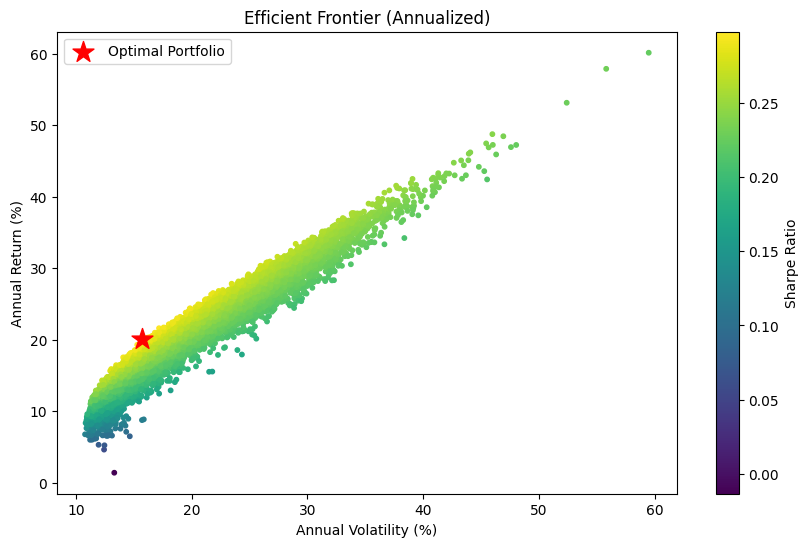

In [128]:
#Plot of Efficient Frontier
num_portfolios = 10000
frontier_results = np.zeros((3, num_portfolios))  # array with returns, volatility and SR per each of 10000 portfolios

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    port_ret, port_vol, port_sharpe = portfolio_perf(weights)
    frontier_results[0, i], frontier_results[1, i], frontier_results[2, i] = port_vol, port_ret, port_sharpe

return_annual = (1 + frontier_results[1, :])**12 - 1
volatility_annual = frontier_results[0, :] * np.sqrt(12)

plt.figure(figsize=(10, 6))
plt.scatter(volatility_annual*100, return_annual*100,
            c=frontier_results[2, :], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(annual_volatility_opt*100, annual_return_opt*100,
            color='red', marker='*', s=250, label='Optimal Portfolio')

plt.title('Efficient Frontier (Annualized)')
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.legend()
plt.show()